In [1]:
import os
import gc
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import skimage
from skimage.feature import hog, canny
from skimage.filters import sobel
from skimage import color

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
import keras.backend as K
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
# from tf_explain.core.activations import ExtractActivations
# from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import get_file

from PIL import Image
from tqdm import tqdm
import random as rnd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
# !pip3 install opencv-python
# !pip install livelossplot
from livelossplot import PlotLossesKeras

%matplotlib inline

In [2]:
train = pd.read_csv('archive/birds.csv')
birds_name = pd.read_csv('archive/birds latin names.csv')
class_dict = pd.read_csv('archive/class_dict.csv')
my_csv = pd.read_csv('archive/my_csv.csv')


In [3]:
train.tail(3)

class index                            filepaths  \
62385          399  valid/YELLOW HEADED BLACKBIRD/3.jpg   
62386          399  valid/YELLOW HEADED BLACKBIRD/4.jpg   
62387          399  valid/YELLOW HEADED BLACKBIRD/5.jpg   

                        labels data set  
62385  YELLOW HEADED BLACKBIRD    valid  
62386  YELLOW HEADED BLACKBIRD    valid  
62387  YELLOW HEADED BLACKBIRD    valid

In [4]:
train_15 = train.iloc[:2465]

In [5]:
birds_name.head(3)

class_index                       class       SCIENTIFIC NAME
0            0             ABBOTTS BABBLER  Malacocincla abbotti
1            1               ABBOTTS BOOBY      Papasula abbotti
2            2  ABYSSINIAN GROUND HORNBILL  Bucorvus abyssinicus

In [6]:
class_dict.head(3)

class_index                       class  height  width  scale by  Offset
0            0             ABBOTTS BABBLER     112    112         1       0
1            1               ABBOTTS BOOBY     112    112         1       0
2            2  ABYSSINIAN GROUND HORNBILL     112    112         1       0

In [7]:
train.reset_index(drop=True, inplace=True)

'train/JACK SNIPE/152.jpg'

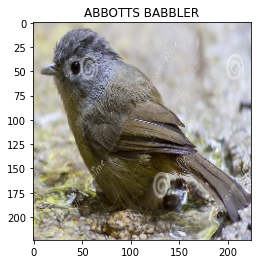

In [8]:
img = Image.open('archive/train/ABBOTTS BABBLER/001.jpg')
plt.imshow(img)
plt.title(train.labels[0])
np.random.choice(train.filepaths)

In [9]:
str(train[train['filepaths']==np.random.choice(train.filepaths)].labels.values)

"['BLACK TAIL CRAKE']"

In [10]:
def fix_path(path):#correct path to be able to open
    new_path = 'archive/' + path
    return new_path

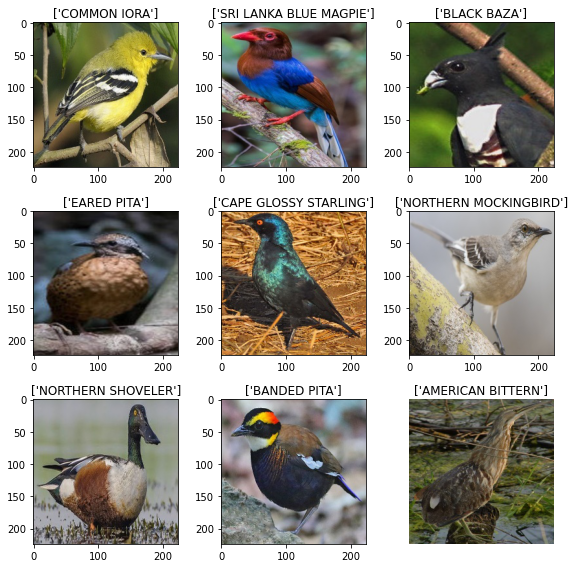

In [11]:
#plot the picture randomly with thier name
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i , ax in enumerate(axs.flat):
    path = np.random.choice(train.filepaths)
    new_path = fix_path(path)
    img = Image.open(new_path)
    ax.imshow(img)
    title = train[train['filepaths']==path].labels.values
    ax.set_title(title)
    plt.axis('off')
plt.tight_layout()

In [12]:
Image.open(fix_path(np.random.choice(train.filepaths))).size

(224, 224)

In [13]:
# read this image in as a NumPy array, using imread from cv2
# image_array = []

# for path in (train.filepaths):
#         new_path = 'archive/'+path
#         M = cv2.imread(new_path)
#         image_array.append(M)

# len(image_array)

# plt.imshow(image_array[1])


In [14]:
# OpenCV also provides you with the option to detect edges in your image. 
# Edge detection is widely used in feature description, 
# image segmentation, image enhancement, image restoration, pattern recognition, and image compression.

def edges_images_gray(class_name, main_df):
    classes_df = main_df[main_df['labels'] ==  class_name].reset_index(drop = True)
    for idx,i in enumerate(np.random.choice(classes_df['filepaths'],1)):
        i = fix_path(i)
        image = cv2.imread(i)
        gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = sobel(image)
        gray_edges=canny(gray)
        dimension = edges.shape
        fig = plt.figure(figsize=(8, 8))
        plt.suptitle(class_name)
        plt.subplot(2,2,1)
        plt.imshow(gray_edges)
        plt.subplot(2,2,2)
        plt.imshow(edges[:dimension[0],:dimension[1],0], cmap="gray")
        plt.subplot(2,2,3)
        plt.imshow(edges[:dimension[0],:dimension[1],1], cmap='gray')
        plt.subplot(2,2,4)
        plt.imshow(edges[:dimension[0],:dimension[1],2], cmap='gray')
        plt.show()

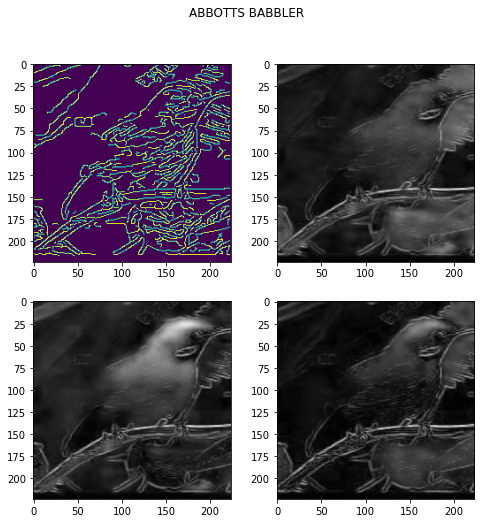

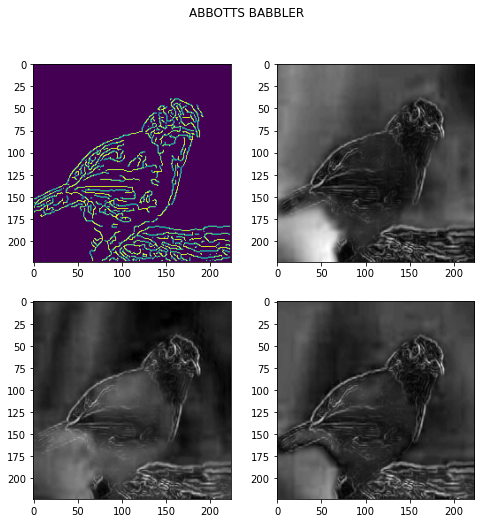

In [15]:
for class_name in train['labels'].iloc[:2]:
    edges_images_gray(class_name, train)

In [16]:
# OpenCV has algorithms available that can allow us to detect corners in an image.
# There are 2 main algorithms used in OpenCV for corner detection: the Harris corner
# detection method and the goodFeaturesToTrack() method.
# We will go over both of these methods in this article for corner detection.
# So first, we import the OpenCV module.
# We then read in the image, Boxes.png.
# We then create the grayscale version of this image.
# We then create a variable, corners, which stores the corners in an image.
# We then create a for loop that loops through of the corners, which we then use the cv2.rectangle() function to create a rectangle around each corner.
# We then show the image.
# And this is corner detection using the goodFeaturesToTrack() method.
# So we can use either the Harris Corner detection method or the goodFeaturesToTrack() detection method for corner detection in Python with OpenCV.
# And this is how we can detect corners in an image in Python using OpenCV.

def corners_images_gray(class_name, main_df):
    classes_df = main_df[main_df['labels'] ==  class_name].reset_index(drop = True)
    for idx,i in enumerate(np.random.choice(classes_df['filepaths'],3)):
        i = fix_path(i)
        image = cv2.imread(i)
        scale_percent = 70
        gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        corners_gray = cv2.goodFeaturesToTrack(gray, maxCorners=70, qualityLevel=0.01, minDistance=10 )
        corners_gray = np.float32(corners_gray)
        for item in corners_gray:
            x, y = item[0]
            cv2.circle(image, (int(x), int(y)), 2, (0, 255, 0), -1)
        fig = plt.figure(figsize=(16, 16))
        plt.suptitle(class_name)
        plt.subplot(2,2,1)
        plt.imshow(image, cmap="BuGn")
        plt.show()

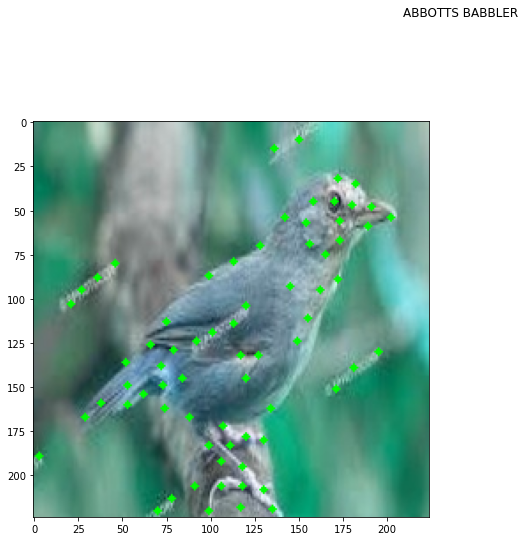

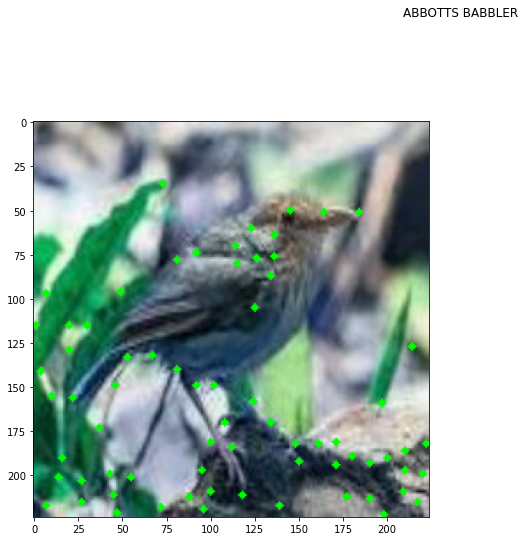

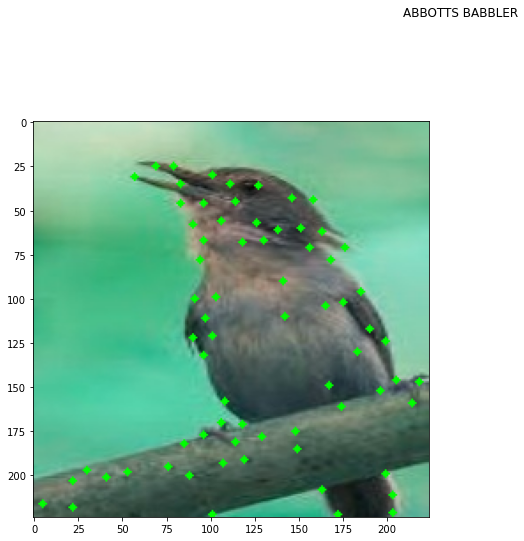

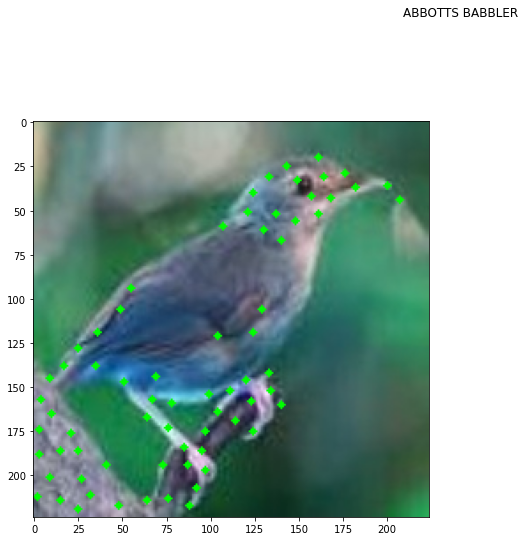

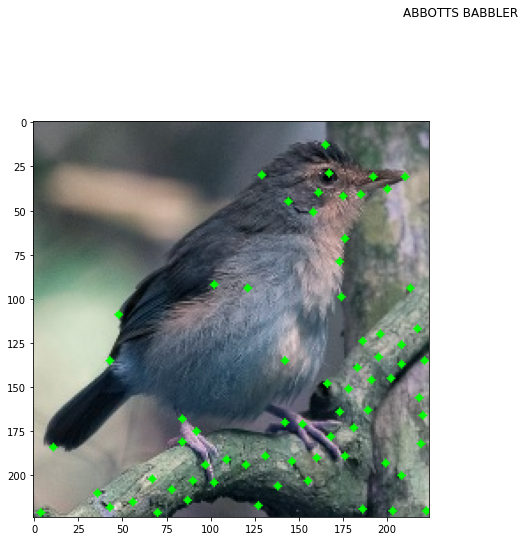

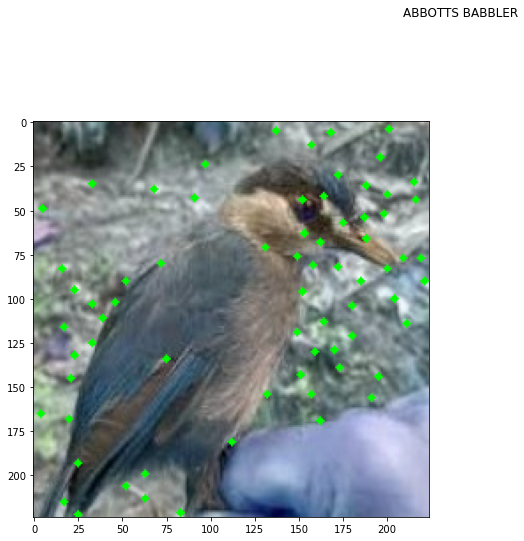

In [17]:
for class_name in train['labels'].iloc[:2]:
    corners_images_gray(class_name, train)

In [19]:
def maske(path):

# opencv loads the image in BGR, convert it to RGB
    img = cv2.cvtColor(cv2.imread('archive/train/ABBOTTS BABBLER/001.jpg'),
                   cv2.COLOR_BGR2RGB)

# load mask and make sure is black&white
    _, mask = cv2.threshold(cv2.imread('archive/train/ABBOTTS BABBLER/001.jpg', 0),
                        0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# load background (could be an image too)
    bk = np.full(img.shape, 255, dtype=np.uint8)  # white bk, same size and type of image
    bk = cv2.rectangle(bk, (0, 0), (int(img.shape[1] / 2), int(img.shape[0] / 2)), 0, -1)  # rectangles
    bk = cv2.rectangle(bk, (int(img.shape[1] / 2), int(img.shape[0] / 2)), (img.shape[1], img.shape[0]), 0, -1)

# get masked foreground
    fg_masked = cv2.bitwise_and(img, img, mask=mask)

# get masked background, mask must be inverted 
    mask = cv2.bitwise_not(mask)
    bk_masked = cv2.bitwise_and(bk, bk, mask=mask)

# combine masked foreground and masked background 
    final = cv2.bitwise_or(fg_masked, bk_masked)
    mask = cv2.bitwise_not(mask)  # revert mask to original
    return img*mask[:,:,np.newaxis]
# plt.imshow(image)
# plt.show()

# sift features

In [20]:
def sift_images_gray(class_name, main_df):
    classes_df = main_df[main_df['labels'] ==  class_name].reset_index(drop = True)
    for idx,i in enumerate(np.random.choice(classes_df['filepaths'],3)):
            i = fix_path(i)
            image = cv2.imread(i)
            gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            sift = cv2.SIFT_create()
            kp, des = sift.detectAndCompute(gray, None)
            kp_img = cv2.drawKeypoints(image, kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            fig = plt.figure(figsize=(16, 16))
            plt.suptitle(class_name)
            plt.subplot(2,2,1)
            plt.imshow(kp_img, cmap="viridis")
            plt.show()

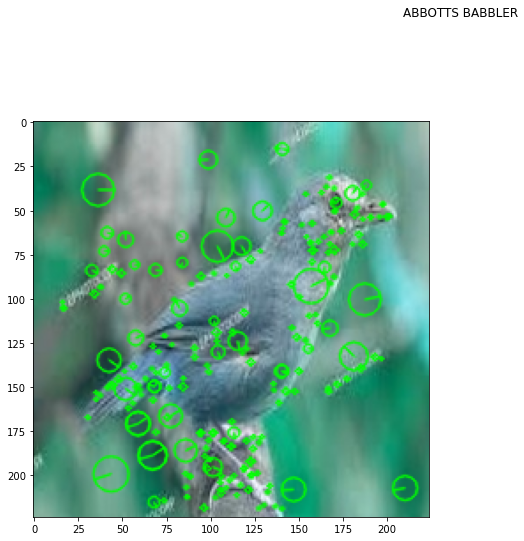

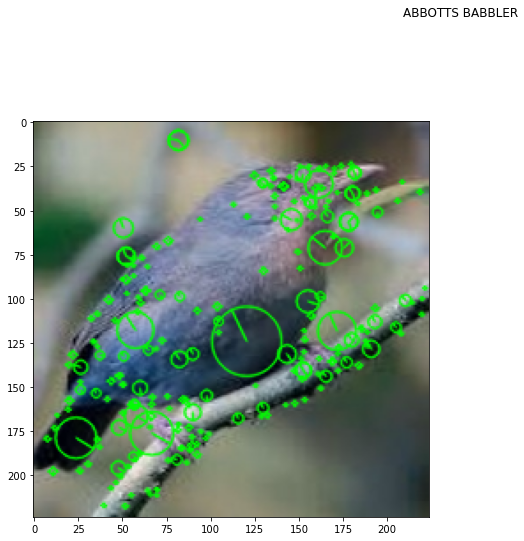

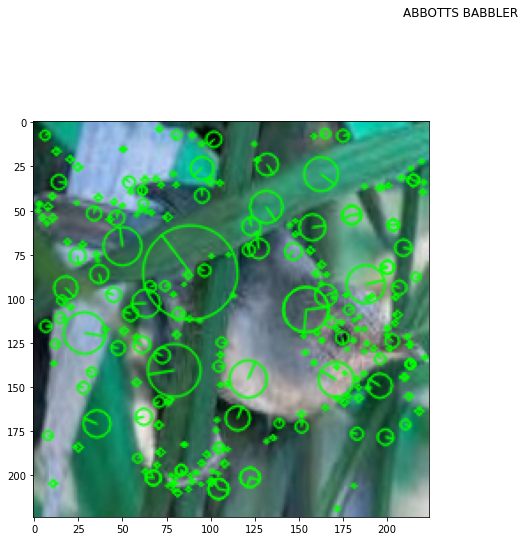

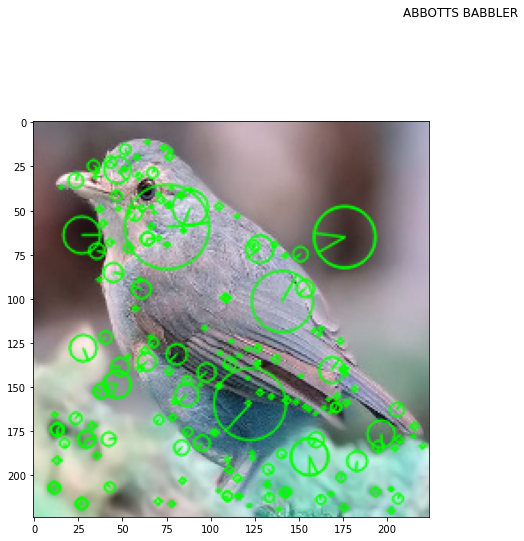

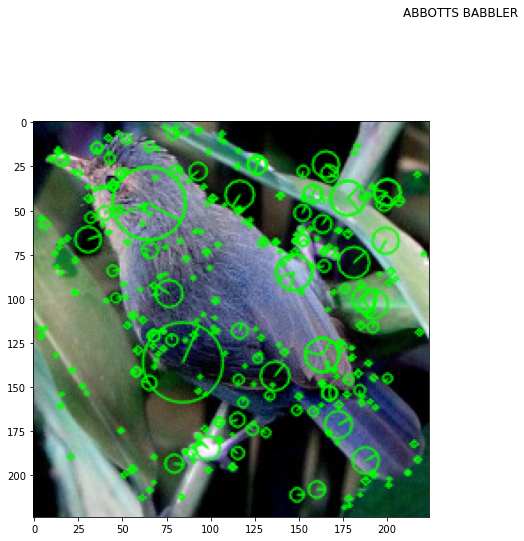

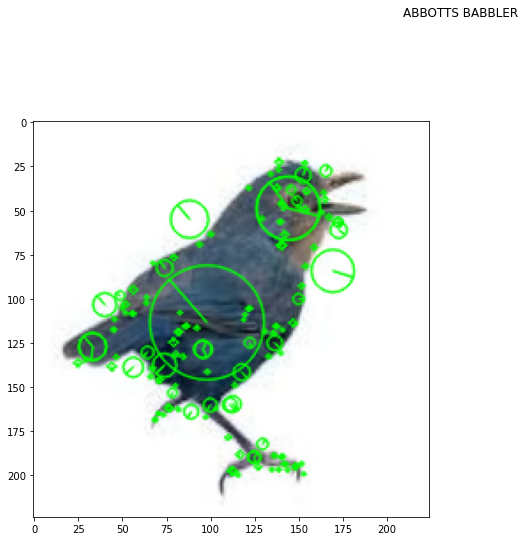

In [21]:
for class_name in train['labels'].iloc[:2]:
    sift_images_gray(class_name, train)

# HOG

In [126]:
def hog_images(class_name, main_df):
    classes_df = main_df[main_df['labels'] ==  class_name].reset_index(drop = True)
    for idx,i in enumerate(np.random.choice(classes_df['filepaths'],3)):
        i = fix_path(i)
        image = cv2.imread(i)
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(9, 9), cells_per_block=(2, 2), visualize=True, multichannel=True)
        fig = plt.figure(figsize=(16, 16))
        plt.suptitle(class_name)
        plt.subplot(2,2,1)
        plt.imshow(hog_image, cmap="gray")
        plt.show()

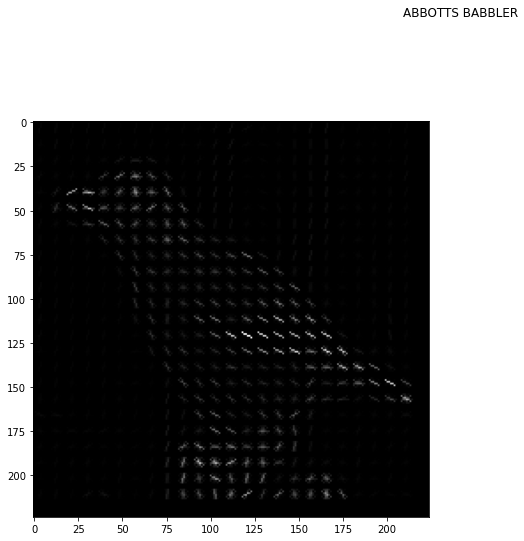

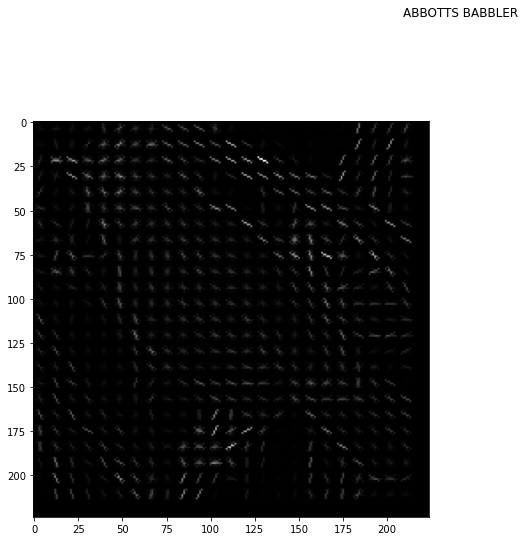

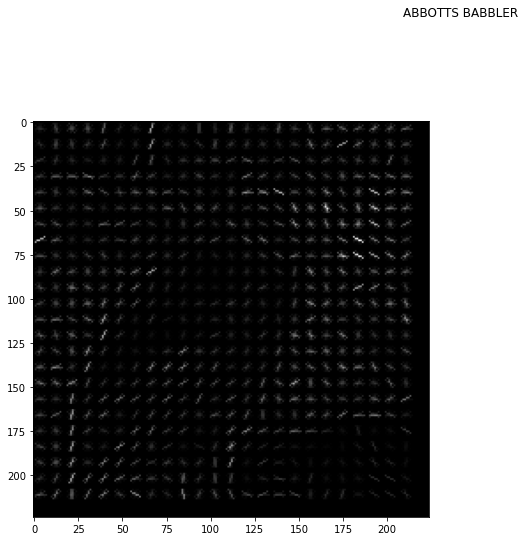

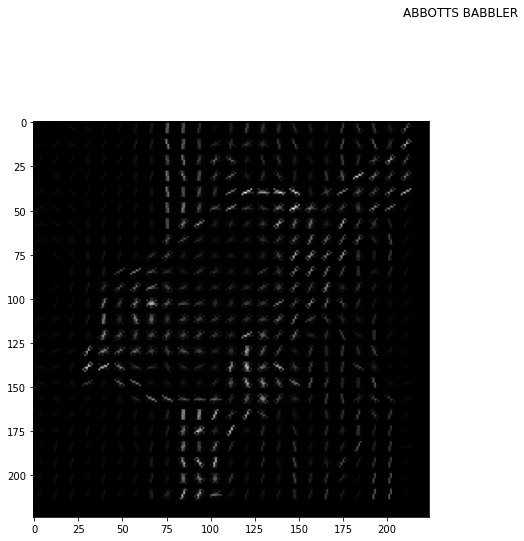

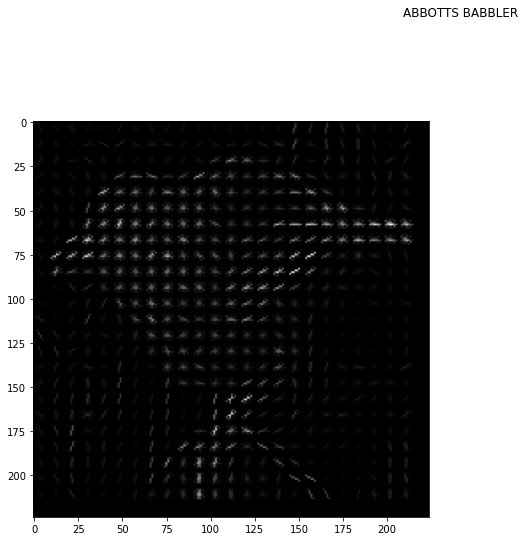

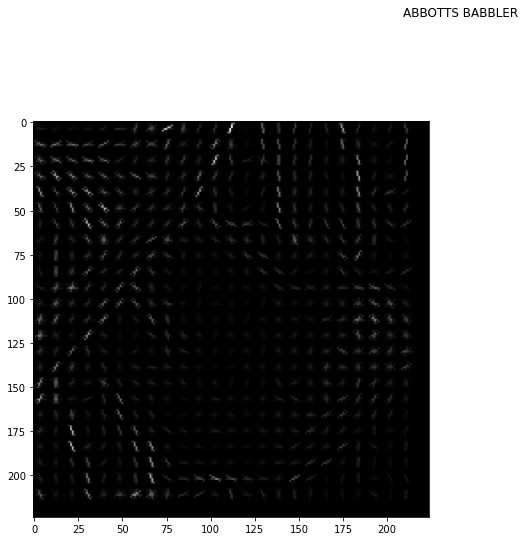

In [127]:
for class_name in train['labels'].iloc[:2]:
    hog_images(class_name, train)

# Augmentations

In [24]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        path = fix_path(path)
        data = Image.open(path)
        data = data.resize((224,224))
        samples = expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

In [30]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[1.2,2],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_vgg = vgg_datagen.flow_from_directory(
    directory='archive/train_15',
    target_size=(112, 112),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
)

val_generator_vgg = vgg_datagen.flow_from_directory(
    directory='archive/valid_15',
    target_size=(112, 112),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
)

Found 2332 images belonging to 16 classes.
Found 75 images belonging to 15 classes.


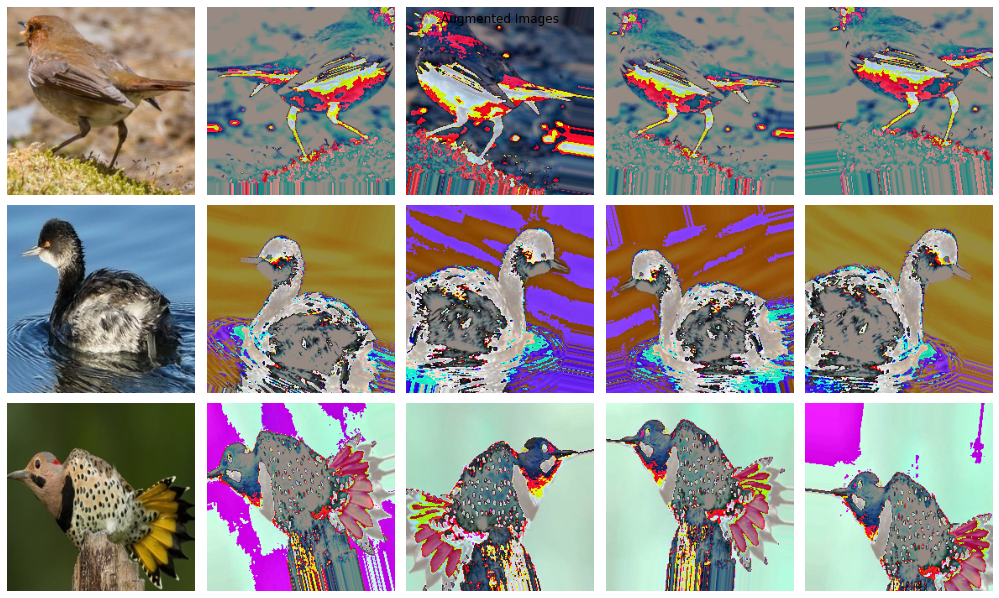

In [31]:
plot_augimages(np.random.choice(train['filepaths'],3), vgg_datagen)

In [32]:
vgg19 = VGG19(include_top = False, input_shape = (112,112,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in vgg19.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg19.output)
predictions = Dense(15, activation='softmax')(x)

model_vgg = Model(inputs = vgg19.input, outputs = predictions)

In [163]:
model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [1]:
history_vgg = model_vgg.fit(
      train_generator_vgg,
      validation_data=val_generator_vgg,
      epochs=5,
      verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [85]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_vgg = vgg_datagen.flow_from_directory(
    directory='archive/train_15',
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
)

val_generator_vgg = vgg_datagen.flow_from_directory(
    directory='archive/valid_15',
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,)



Found 2332 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


In [86]:
vgg19 = VGG19(include_top = False, input_shape = (112,112,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in vgg19.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg19.output)
predictions = Dense(15, activation='softmax')(x)

model_vgg = Model(inputs = vgg19.input, outputs = predictions)

In [87]:
model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [88]:
history_vgg = model_vgg.fit(
      train_generator_vgg,
      validation_data=val_generator_vgg,
      epochs=5,
      verbose=2)

Epoch 1/5


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\zmaso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-88-54ebf8169231>", line 1, in <module>
    history_vgg = model_vgg.fit(
  File "C:\Users\zmaso\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\zmaso\anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\zmaso\anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\zmaso\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\zmaso\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 947, in _call
    re


KeyboardInterrupt



In [76]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# y_train = utils.to_categorical(y_train, num_classes)
# y_test = utils.to_categorical(y_test, num_classes)
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2)
# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(train['filepaths'])
# # fits the model on batches with real-time data augmentation:
# model.fit(datagen.flow(train['filepaths'], train['labels'], batch_size=32,
#          subset='training'),
#          validation_data=datagen.flow(train['filepaths'], train['labels'],
#          batch_size=8, subset='validation'),
#          steps_per_epoch=len(x_train) / 32, epochs=epochs)
# # here's a more "manual" example
# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in datagen.flow(train['filepaths'], train['labels'], batch_size=32):
#         model.fit(x_batch, y_batch)
#         batches += 1
#         if batches >= len(train['filepaths']) / 32:
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break

In [79]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224))
        samples = expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

In [81]:
# plot_augimages(np.random.choice('train/ABBOTTS BABBLER/001.jpg'), vgg_datagen)